In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.applications import vgg19

In [2]:
content = plt.imread('/content/lion.jpg')
style = plt.imread('/content/giger_crop.jpg')

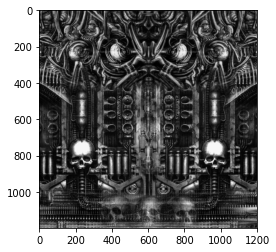

In [10]:
plt.imshow(style)

In [11]:
def content_loss(image,generated):
  return tf.reduce_sum(tf.square(generated - image))

In [12]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [13]:
def style_cost(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_width * img_height
    return tf.reduce_sum(tf.square(S - C)) / (4 * (channels ** 2.0) * (size ** 2))

In [14]:
model = vgg19.VGG19(weights='imagenet', include_top=False)


In [15]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [16]:
outputs_dict= dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [17]:
style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_layer = "block5_conv2"

content_weight = 2.4e-8
style_weight = 3e-6

def loss_function(combination_image, base_image, style_image):

    input_tensor = tf.concat(
        [base_image, style_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    loss =0
    layer_features = features[content_layer]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]

    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )

    for layer_name in style_layers:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_cost(style_image, combination_features)
        loss += (style_weight / len(style_layers)) * sl

    return loss

In [18]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = loss_function(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [19]:
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

In [20]:
def deprocess_image(tensor):

    tensor = tensor.reshape((img_width, img_height, 3))
    tensor[:, :, 0] += 104.1
    tensor[:, :, 1] += 116.8
    tensor[:, :, 2] += 123.88
    tensor = tensor[:, :, ::-1]
    tensor = np.clip(tensor, 0, 255).astype("uint8")

    return tensor

In [21]:
def result_saver(iteration):

    image_name="New"+str(iteration)+".jpg"
    img = deprocess_image(combination_image.numpy())
    tf.keras.preprocessing.image.save_img(image_name, img)

In [23]:
width, height = tf.keras.preprocessing.image.load_img('/content/lion.jpg').size
img_width = 400
img_height = 450

optimizer = tf.keras.optimizers.SGD(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.81
    )
)

base_image = preprocess_image('/content/lion.jpg')
style_image = preprocess_image('/content/giger_crop.jpg')
combination_image = tf.Variable(preprocess_image('/content/lion.jpg'))

iterations = 1000

for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 200 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        result_saver(i)

Iteration 200: loss=1371.04
Iteration 400: loss=932.32
Iteration 600: loss=768.11
Iteration 800: loss=674.69
Iteration 1000: loss=612.66


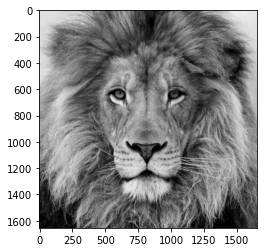

In [33]:
plt.imshow(content)

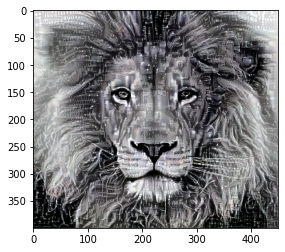

In [31]:
combination_image=combination_image.numpy().reshape(img_nrows,img_ncols,3)

combination_image[:, :, 0] += 104.1
combination_image[:, :, 1] += 116.8
combination_image[:, :, 2] += 123.88

combination_image = combination_image[:, :, ::-1]

combination_image = np.clip(combination_image, 0, 255).astype("uint8")

plt.imshow(combination_image)